In [1]:
import os
import pickle

import numpy as np
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._dkt import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_dkt"
            ),
            "model.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (X): Embedding(259, 20)
  (gru): GRU(40, 20, batch_first=True)
  (out_layer): Linear(in_features=20, out_features=259, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
)

In [14]:
with open(
    os.path.join(
        os.path.join(
            ckpt_path, "_dkt"
        ),
        "test_loss_means.pkl"
    ),
    "rb"
) as f:
    test_loss_means = pickle.load(f)

In [16]:
np.min(test_loss_means)

0.019989375

In [4]:
test_dataset[100]

(array([ 9,  9,  9,  9,  9,  9,  9,  6,  9,  6,  9,  0,  0,  6,  6,  0, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0.5       , 0.5       , 0.5       , 0.02686082, 0.5       ,
        0.00330315, 0.5       , 0.5       , 0.07490542, 0.10676611,
        0.1694675 , 0.06937618, 0.16020819, 0.1841959 , 0.1228058

In [5]:
# 3등급 전처리: 0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 19, 21, 100, 101
# 임의 전처리: 1, 2, 3, 4
# basis = 1.0: 0, 2, 4, 6, 7
# basis = 0.5: 0, 2, 3, 7, 100
c_seq, d_seq, r_seq = test_dataset[100]

c_seq, cshft_seq, d_seq, dshft_seq, r_seq, rshft_seq = \
[c_seq[:-1]], [c_seq[1:]], [d_seq[:-1]], [d_seq[1:]], [r_seq[:-1]], [r_seq[1:]]

# r_seq = np.zeros_like(r_seq)
r_seq = np.ones_like(r_seq)

d_seq = np.ones_like(d_seq) * 5

###########################################
# alpha_seq, beta_seq, beta_shft_seq, gamma_seq, gamma_shft_seq, h_seq, C_seq = model(
#     LongTensor(c_seq),
#     LongTensor(cshft_seq),
#     LongTensor(d_seq),
#     LongTensor(dshft_seq),
#     FloatTensor(r_seq),
# )
###########################################
# alpha_seq, h_seq, C_seq = model(
#     LongTensor(c_seq),
#     LongTensor(d_seq),
#     FloatTensor(r_seq),
# )

# # c_one_hot_seq: [batch_size, seq_len, 1, num_c]
# c_one_hot_seq = one_hot(LongTensor(c_seq), model.num_c).float()
# c_one_hot_seq = torch.reshape(
#     c_one_hot_seq,
#     shape=[
#         -1,
#         c_one_hot_seq.shape[1],
#         c_one_hot_seq.shape[2]
#     ]
# ).unsqueeze(-2)
# beta_seq = torch.bmm(
#     torch.reshape(
#         c_one_hot_seq,
#         shape=[
#             -1,
#             c_one_hot_seq.shape[2],
#             c_one_hot_seq.shape[3]
#         ]
#     ),
#     torch.reshape(
#         C_seq, shape=[-1, C_seq.shape[2], C_seq.shape[3]]
#     )
# )
# beta_seq = torch.reshape(
#     beta_seq, shape=[1, seq_len]
# )

# gamma_seq = model.D1(LongTensor(d_seq)).squeeze()
###########################################
alpha_seq, h_seq = model(
    LongTensor(c_seq),
    LongTensor(d_seq),
    FloatTensor(r_seq),
)
alpha_seq = alpha_seq.squeeze()

C_seq = alpha_seq.mean(-1)
alpha_seq = C_seq.mean(-1)
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()

# sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta_seq).detach().cpu().numpy()[0]

# sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ_seq = torch.sigmoid(C_seq.squeeze() + alpha_seq.unsqueeze(-1)).detach().cpu().numpy()
C_seq = C_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

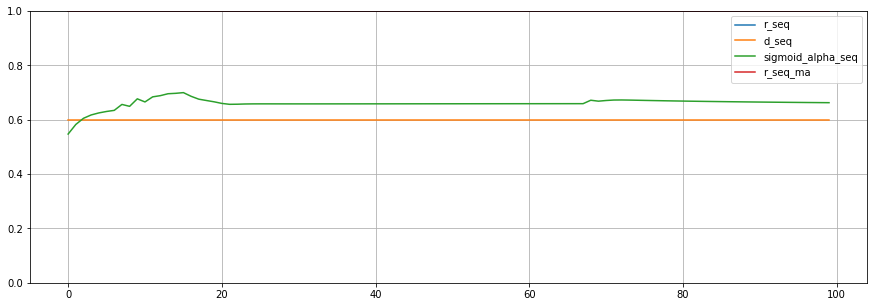

In [6]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
# plt.plot(sigmoid_alpha_beta_gamma_seq, label="sigmoid_alpha_beta_gamma_seq")
plt.plot(r_seq_ma, label="r_seq_ma")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

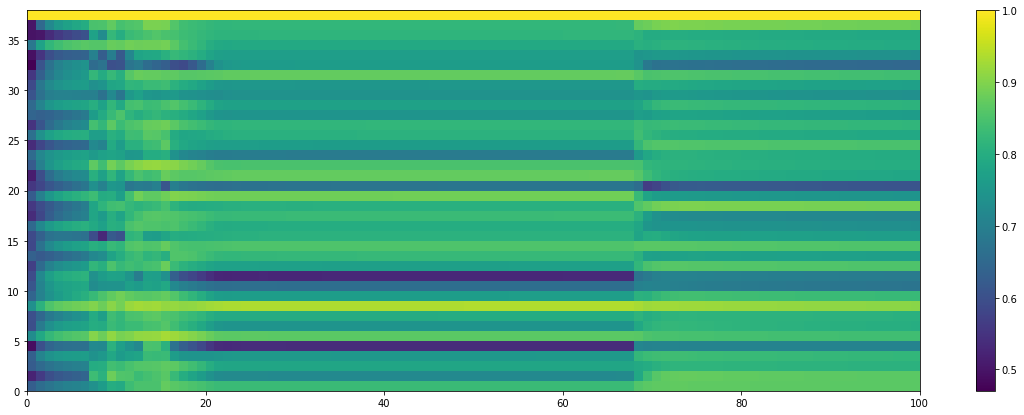

In [7]:
plt.figure(figsize=[20, 7], facecolor="white")
temp = np.concatenate([CQ_seq.T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [8]:
CQ_seq[0], CQ_seq[-1], c_seq

(array([0.62598   , 0.5211342 , 0.6230869 , 0.6302631 , 0.48888958,
        0.72645813, 0.5972449 , 0.6003832 , 0.73354465, 0.64196914,
        0.61142224, 0.5904551 , 0.56945574, 0.6332467 , 0.5848202 ,
        0.58891004, 0.64962083, 0.53515095, 0.5562798 , 0.6232657 ,
        0.55480415, 0.51234204, 0.6201853 , 0.6538015 , 0.5358918 ,
        0.6636012 , 0.548164  , 0.641808  , 0.65124667, 0.60820407,
        0.59016293, 0.5531286 , 0.47027493, 0.49221137, 0.68235505,
        0.49541906, 0.5001717 ], dtype=float32),
 array([0.86383164, 0.8636599 , 0.8081566 , 0.81913555, 0.7075051 ,
        0.8368084 , 0.8010105 , 0.80717057, 0.9065687 , 0.82663846,
        0.6744576 , 0.6881879 , 0.85153055, 0.7663456 , 0.8510549 ,
        0.76452774, 0.7307655 , 0.7156216 , 0.88699293, 0.7447587 ,
        0.6074173 , 0.78397775, 0.7976306 , 0.7934417 , 0.84794784,
        0.7869619 , 0.81741536, 0.7611731 , 0.81108516, 0.734571  ,
        0.76962173, 0.83741575, 0.64663637, 0.7348137 , 0.79128134,

In [9]:
x = np.arange(0.001, 1.501, 0.001)

In [10]:
x

array([1.000e-03, 2.000e-03, 3.000e-03, ..., 1.498e+00, 1.499e+00,
       1.500e+00])

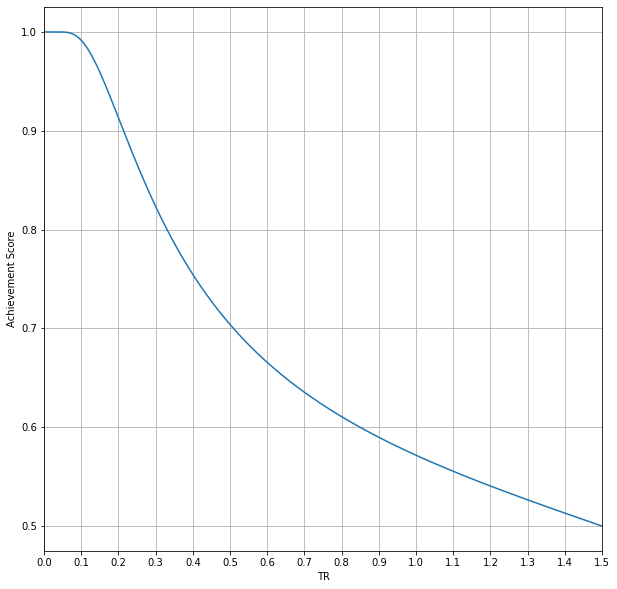

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.arange(0.001, 1.501, 0.001)

plt.figure(figsize=[10, 10], facecolor="white")
plt.plot(x, sigmoid(0.5 * (np.tan((np.pi / 2) - (x * np.pi / 3)))))
plt.xlabel("TR")
plt.ylabel("Achievement Score")
plt.grid()
plt.xlim(0, 1.5)
plt.xticks(np.arange(0.0, 1.6, 0.1))

plt.show()

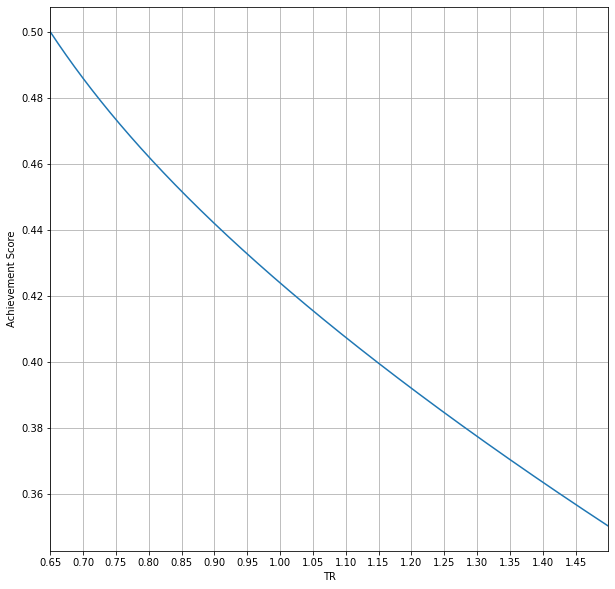

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.arange(0.65, 1.501, 0.001)

plt.figure(figsize=[10, 10], facecolor="white")
plt.plot(x, sigmoid(-0.5 * (np.tan((np.pi / 2) - ((1 / x) * np.pi * 0.65 / 2)))))
plt.xlabel("TR")
plt.ylabel("Achievement Score")
plt.grid()
plt.xlim(0.65, 1.5)
plt.xticks(np.arange(0.65, 1.5, 0.05))

plt.show()